In [39]:
import pandas as pd
df = pd.read_csv("C:/Users/user/Documents/에이콘아카데미/최종/통합/ml_gb.csv")
df.drop(columns ='Unnamed: 0',inplace = True)
df.to_csv("C:/Users/user/Documents/에이콘아카데미/최종/통합/ml_gb.csv",index = False)

## 상관분석

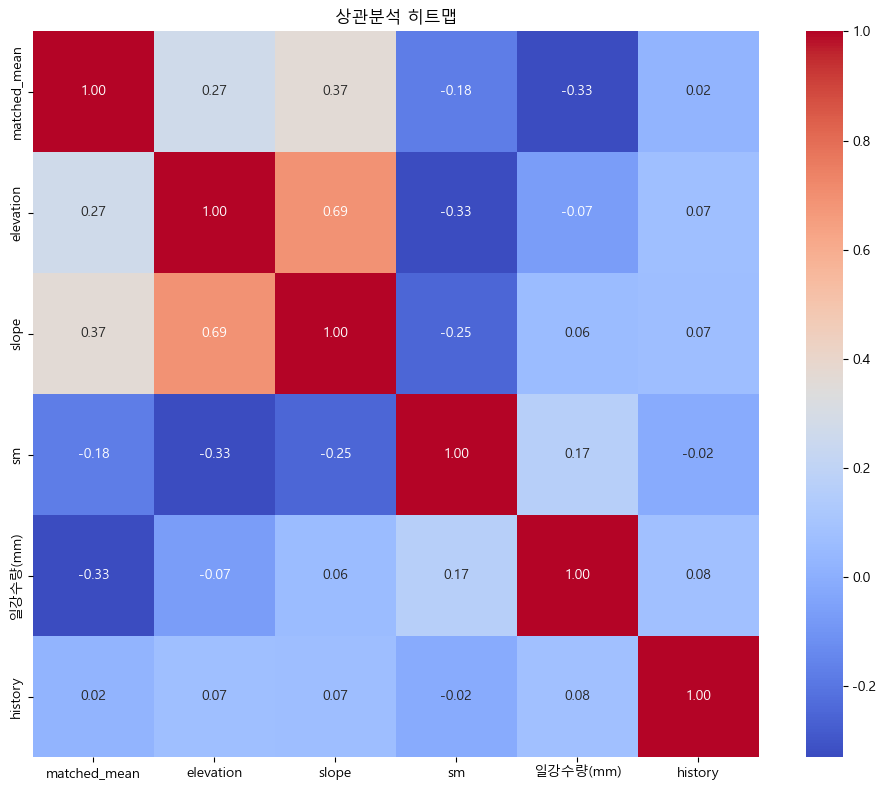

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   # 한글 폰트 지정
mpl.rcParams['axes.unicode_minus'] = False      # 음수 기호 깨짐 방지

warnings.filterwarnings("ignore")
# 숫자형 변수만 선택
numeric_df = df.select_dtypes(include='number')

# 상관계수 계산
corr_matrix = numeric_df.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("상관분석 히트맵")
plt.tight_layout()
plt.show()

## 피어슨 상관관계

In [44]:
df.corr(method='pearson')

,matched_mean,elevation,slope,sm,일강수량(mm),history
matched_mean,1.000000,0.272668,0.366070,-0.176041,-0.326757,0.023403
elevation,0.272668,1.000000,0.692552,-0.329162,-0.068170,0.070904
slope,0.366070,0.692552,1.000000,-0.251048,0.057307,0.068758
sm,-0.176041,-0.329162,-0.251048,1.000000,0.166541,-0.015222
일강수량(mm),-0.326757,-0.068170,0.057307,0.166541,1.000000,0.075892
history,0.023403,0.070904,0.068758,-0.015222,0.075892,1.000000


## 다중공선성 분석

In [47]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# X는 독립변수 데이터프레임 (종속변수 history 제외)
X = df.drop(columns=['history'])

# 상수항 추가 (Intercept)
X_const = add_constant(X)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)


        feature       VIF
0  matched_mean  1.345484
1     elevation  2.050448
2         slope  2.194896
3            sm  1.153379
4      일강수량(mm)  1.216341


## 통계검정 -- 부트스트랩, T-검정

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# 데이터 로드
df = pd.read_csv("ml_gb.csv")

# 타겟과 피처 분리
features = ['matched_mean', 'elevation', 'slope', 'sm', '일강수량(mm)']
target = 'history'

# 부트스트랩 함수
def bootstrap_ci(data1, data2, n_bootstrap=1000, ci=95):
    boot_diff_means = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diff_mean = np.mean(sample1) - np.mean(sample2)
        boot_diff_means.append(diff_mean)
    lower = np.percentile(boot_diff_means, (100 - ci) / 2)
    upper = np.percentile(boot_diff_means, 100 - (100 - ci) / 2)
    return lower, upper

# 결과 저장
bootstrap_results = {}
t_test_results = {}

for col in features:
    group1 = df[df[target] == 1][col].dropna()
    group0 = df[df[target] == 0][col].dropna()

    # 부트스트랩 신뢰구간
    lower, upper = bootstrap_ci(group1.values, group0.values)
    bootstrap_results[col] = [lower, upper]

    # t-test
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    t_test_results[col] = [t_stat, p_val]

# 데이터프레임 변환
bootstrap_df = pd.DataFrame(bootstrap_results, index=["2.5%", "97.5%"]).T
ttest_df = pd.DataFrame(t_test_results, index=["t-statistic", "p-value"]).T

# 출력
print("\n[ Bootstrap 기반 95% 신뢰구간 ]")
print(bootstrap_df)

print("\n[ T-Test 결과 ]")
print(ttest_df)



[ Bootstrap 기반 95% 신뢰구간 ]
                   2.5%      97.5%
matched_mean   0.006877   0.024969
elevation     48.908696  72.076711
slope          1.432870   2.038467
sm            -1.012724  -0.118978
일강수량(mm)       8.814189  14.068233

[ T-Test 결과 ]
              t-statistic       p-value
matched_mean     3.466234  5.403391e-04
elevation        9.977157  7.688875e-23
slope           10.948540  4.633555e-27
sm              -2.470029  1.360085e-02
일강수량(mm)         8.571648  2.274710e-17
